# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

## Step 1: Data preparation

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import time
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random
from torch.utils.tensorboard import SummaryWriter


1. Load CNN dataset.

In [4]:
import zipfile
import os

zip_path = "/content/cnn_dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
     zip_ref.extractall("/content/cnn_dataset")


dataset_path = "cnn_dataset"

print(f"Dataset is: {dataset_path}")

Dataset is: cnn_dataset


In [5]:
dataset_path = "./cnn_dataset"

transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.classes}")
print(f"Number of classes: {len(dataset.classes)}")

for i in range(5):
    image, label = dataset[i]
    print(f"Sample {i+1}: Label - {label}, Class - {dataset.classes[label]}, Image Shape: {image.shape}")


Total images: 30000
Classes: ['dogs', 'food', 'vehicles']
Number of classes: 3
Sample 1: Label - 0, Class - dogs, Image Shape: torch.Size([3, 64, 64])
Sample 2: Label - 0, Class - dogs, Image Shape: torch.Size([3, 64, 64])
Sample 3: Label - 0, Class - dogs, Image Shape: torch.Size([3, 64, 64])
Sample 4: Label - 0, Class - dogs, Image Shape: torch.Size([3, 64, 64])
Sample 5: Label - 0, Class - dogs, Image Shape: torch.Size([3, 64, 64])


The dataset consists of 30,000 RGB images (64x64 pixels) evenly distributed among three classes: dogs, food, and vehicles (10,000 images each). The images are well-structured and suitable for multi-class image classification tasks using CNNs.

2. VISUALIZATIONS

Class Distribution:
dogs: 10000 images
food: 10000 images
vehicles: 10000 images


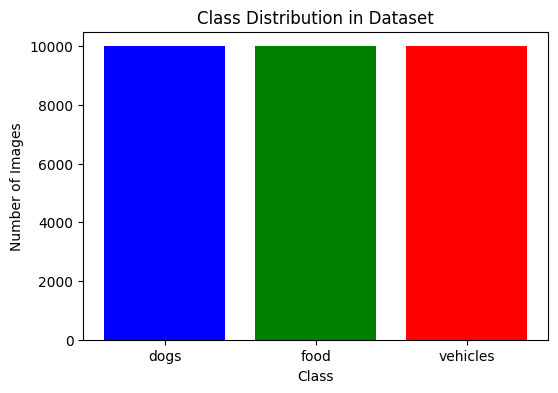

In [6]:
class_counts = Counter([label for _, label in dataset])

class_labels = dataset.classes
counts = [class_counts[i] for i in range(len(class_labels))]

print("Class Distribution:")
for label, count in zip(class_labels, counts):
    print(f"{label}: {count} images")

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(class_labels, counts, color=['blue', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()


This bar chart shows that the dataset is perfectly balanced, with each class containing 10,000 images. A balanced dataset ensures that the model does not develop a bias toward any particular class during training.

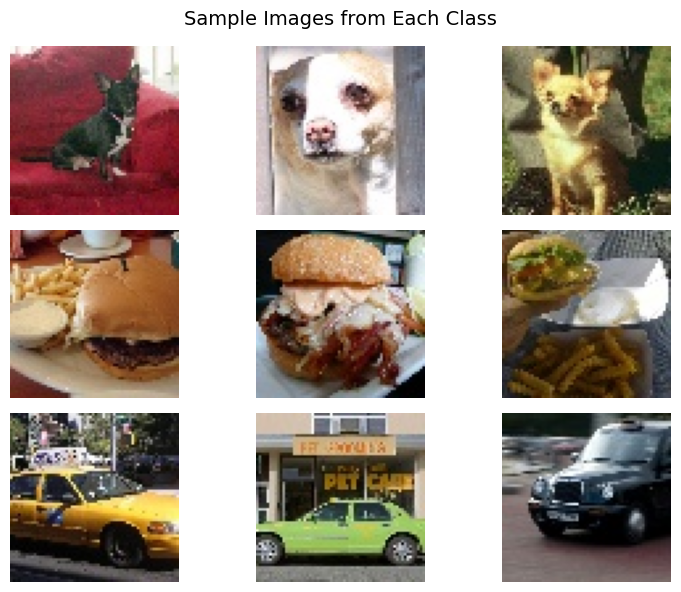

In [7]:
def show_sample_images(dataset, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(8, 6))

    for class_idx, class_name in enumerate(class_names):
        class_images = [img for img, label in dataset if label == class_idx][:num_samples]

        for i, img in enumerate(class_images):
            img = img.permute(1, 2, 0).numpy()
            axes[class_idx, i].imshow(img)
            axes[class_idx, i].axis("off")

        axes[class_idx, 0].set_ylabel(class_name, fontsize=12, rotation=90, labelpad=10)

    plt.suptitle("Sample Images from Each Class", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(dataset, dataset.classes)


This grid provides a overview of the types of images in the dataset. By showcasing a few examples from each class, it helps understand the intra-class variations (differences among images in the same class) and inter-class distinctions (differences between classes).

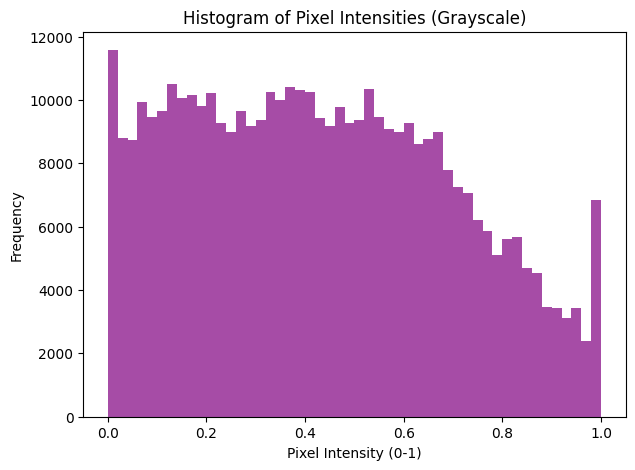

In [8]:
def plot_pixel_distribution(dataset, num_samples=100):
    pixel_values = []

    for i in range(num_samples):
        img, _ = dataset[i]
        img_gray = img.mean(dim=0)
        pixel_values.extend(img_gray.flatten().numpy())

    plt.figure(figsize=(7, 5))
    plt.hist(pixel_values, bins=50, color='purple', alpha=0.7)
    plt.xlabel("Pixel Intensity (0-1)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Pixel Intensities (Grayscale)")
    plt.show()

plot_pixel_distribution(dataset)


The histogram highlights the distribution of pixel intensities. A relatively uniform distribution indicates that images have a variety of brightness levels, while peaks at 0 or 1 can signal overexposed or underexposed images.

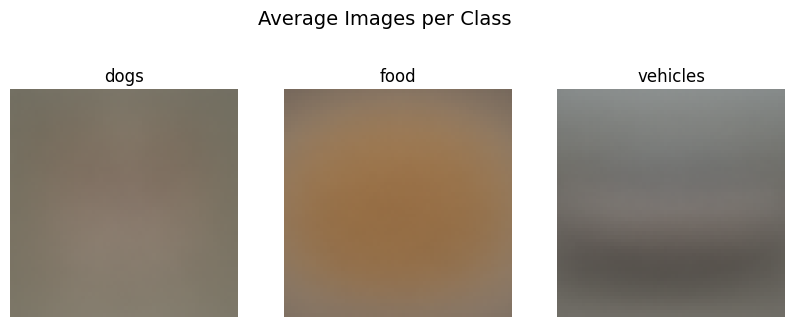

In [9]:
def compute_average_image(dataset, class_names):
    average_images = []

    for class_idx, class_name in enumerate(class_names):
        class_images = [img for img, label in dataset if label == class_idx]
        avg_img = torch.stack(class_images, dim=0).mean(dim=0)
        average_images.append((class_name, avg_img))

    return average_images

def display_average_images(average_images):
    plt.figure(figsize=(10, 4))
    for i, (class_name, avg_img) in enumerate(average_images):
        plt.subplot(1, len(average_images), i + 1)
        plt.imshow(avg_img.permute(1, 2, 0).numpy())
        plt.title(class_name)
        plt.axis("off")
    plt.suptitle("Average Images per Class", fontsize=14)
    plt.show()

average_images = compute_average_image(dataset, dataset.classes)
display_average_images(average_images)


This visualization displays the average image for each class, created by averaging the pixel values of all images in that class. It helps identify class-specific patterns and color distributions.

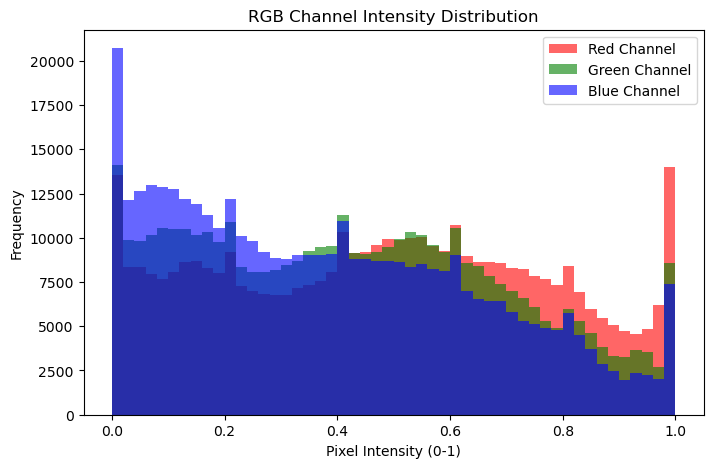

In [ ]:
def plot_rgb_distribution(dataset, num_samples=100):
    r_values, g_values, b_values = [], [], []

    for i in range(num_samples):
        img, _ = dataset[i]  
        r_values.extend(img[0].flatten().numpy())  
        g_values.extend(img[1].flatten().numpy())  
        b_values.extend(img[2].flatten().numpy())  

    plt.figure(figsize=(8, 5))
    plt.hist(r_values, bins=50, color='red', alpha=0.6, label="Red Channel")
    plt.hist(g_values, bins=50, color='green', alpha=0.6, label="Green Channel")
    plt.hist(b_values, bins=50, color='blue', alpha=0.6, label="Blue Channel")

    plt.xlabel("Pixel Intensity (0-1)")
    plt.ylabel("Frequency")
    plt.title("RGB Channel Intensity Distribution")
    plt.legend()
    plt.show()

plot_rgb_distribution(dataset)


In [ ]:
def compute_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_pixels = 0

    for img, _ in dataset:
        num_pixels += img.shape[1] * img.shape[2]  
        mean += img.sum(dim=(1, 2)) 
        std += (img ** 2).sum(dim=(1, 2))  

    mean /= num_pixels
    std = (std / num_pixels - mean ** 2).sqrt()  

    return mean, std

mean, std = compute_mean_std(dataset)
print(f"Computed Mean: {mean.tolist()}")
print(f"Computed Std: {std.tolist()}")


Computed Mean: [0.5047495365142822, 0.4501127600669861, 0.3840372860431671]
Computed Std: [0.2746628224849701, 0.2668818235397339, 0.2770591080188751]


3. PREPROCESS DATASET

In [ ]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5047, 0.4501, 0.3840], std=[0.2746, 0.2668, 0.2770]) 
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5047, 0.4501, 0.3840], std=[0.2746, 0.2668, 0.2770])
])



4. SPLIT DATASET

In [ ]:
full_dataset = ImageFolder(root=dataset_path)

total_size = len(full_dataset)  
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)  # 10% for validation
test_size = total_size - train_size - val_size  # 10% for testing

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset = Subset(ImageFolder(root=dataset_path, transform=train_transforms), train_dataset.indices)
val_dataset = Subset(ImageFolder(root=dataset_path, transform=test_transforms), val_dataset.indices)
test_dataset = Subset(ImageFolder(root=dataset_path, transform=test_transforms), test_dataset.indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Total Images: {total_size}")
print(f"Training Set: {len(train_dataset)} images")
print(f"Validation Set: {len(val_dataset)} images")
print(f"Test Set: {len(test_dataset)} images")

Total Images: 30000
Training Set: 24000 images
Validation Set: 3000 images
Test Set: 3000 images


STEP 2: IMPLEMENTING VGG

In [ ]:
# Define VGG-16 Model
class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),  # Adjusted for 64x64 input
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output for 3 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VGG16(num_classes=3)
print(model)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

2) XAVIER AND HE INITIALIZATION

In [ ]:
def initialize_weights(model, init_type="xavier"):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if init_type == "xavier":
                init.xavier_uniform_(m.weight)  # Xavier Initialization
            elif init_type == "he":
                init.kaiming_uniform_(m.weight, nonlinearity="relu")  # He Initialization
            if m.bias is not None:
                init.constant_(m.bias, 0)  

vgg_xavier = VGG16(num_classes=3)
initialize_weights(vgg_xavier, init_type="xavier")

vgg_he = VGG16(num_classes=3)
initialize_weights(vgg_he, init_type="he")

3a) TRAINED VGG-16 WITH THREE DIFF OPTIMIZERS

In [ ]:
learning_rate = 0.001
weight_decay = 1e-4 

optimizers = {
    "SGD": optim.SGD(vgg_xavier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay),
    "Adam": optim.Adam(vgg_xavier.parameters(), lr=learning_rate, weight_decay=weight_decay),
    "AdamW": optim.AdamW(vgg_xavier.parameters(), lr=learning_rate, weight_decay=weight_decay)
}

for name, opt in optimizers.items():
    print(f"{name} Optimizer: {opt}")


SGD Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Adam Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
AdamW Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [ ]:

batch_sizes = [32, 64]

train_loaders = {
    batch_size: DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    for batch_size in batch_sizes
}

for batch_size, loader in train_loaders.items():
    print(f"DataLoader for Batch Size {batch_size}: {len(loader)} batches per epoch")


DataLoader for Batch Size 32: 750 batches per epoch
DataLoader for Batch Size 64: 375 batches per epoch


In [ ]:
def train_vgg16(model, train_loader, val_loader, optimizer, criterion, epochs=10, device="mps"):
    model.to(device)  
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() 

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train
        train_loss /= total_train

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels).sum().item()
                total_val += labels.size(0)

        val_acc = 100 * correct_val / total_val
        val_loss /= total_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_xavier.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
train_loader = train_loaders[32]




In [ ]:
import torch

print("PyTorch Version:", torch.__version__)
print("Is MPS Available:", torch.backends.mps.is_available())
print("Is MPS Built:", torch.backends.mps.is_built())


PyTorch Version: 2.6.0
Is MPS Available: True
Is MPS Built: True


In [ ]:
# Use MPS if available, otherwise fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


 ----------------- Xavier+SGD+32 ------------------------------

In [ ]:
history_xavier_sgd_32 = train_vgg16(vgg_xavier, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)

Using device: mps
Epoch [1/5] | Train Loss: 0.2917 | Train Acc: 89.55% | Val Loss: 0.2682 | Val Acc: 90.27%
Epoch [2/5] | Train Loss: 0.2731 | Train Acc: 90.05% | Val Loss: 0.2455 | Val Acc: 91.30%
Epoch [3/5] | Train Loss: 0.2695 | Train Acc: 90.30% | Val Loss: 0.2569 | Val Acc: 91.03%
Epoch [4/5] | Train Loss: 0.2605 | Train Acc: 90.57% | Val Loss: 0.2485 | Val Acc: 91.07%
Epoch [5/5] | Train Loss: 0.2530 | Train Acc: 90.91% | Val Loss: 0.2509 | Val Acc: 90.97%


In [ ]:
torch.save(vgg_xavier.state_dict(), "vgg16_xavier_sgd_32.pth")
print("\n Model weights saved as vgg16_xavier_sgd_32.pth")


 Model weights saved as vgg16_xavier_sgd_32.pth


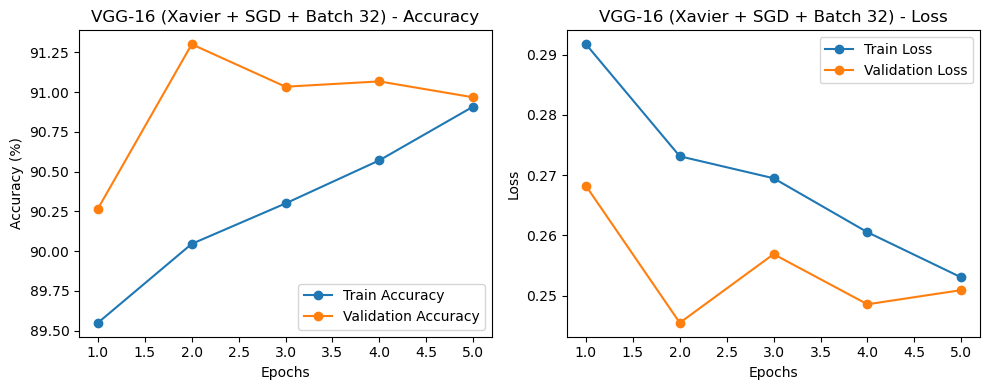

In [ ]:
def plot_training_curves(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_xavier_sgd_32, title="VGG-16 (Xavier + SGD + Batch 32)")


In [ ]:
def evaluate_model(model, test_loader, device="mps"):
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds) * 100
    print(f"\n Test Accuracy: {test_acc:.2f}%")

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.dataset.classes, yticklabels=test_loader.dataset.dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # classification report (Precision, Recall, F1-score)
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.dataset.classes))


 Test Accuracy: 90.73%


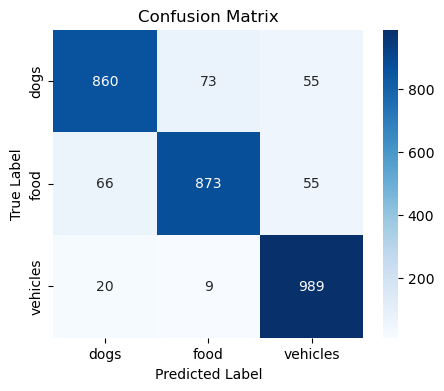


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.91      0.87      0.89       988
        food       0.91      0.88      0.90       994
    vehicles       0.90      0.97      0.93      1018

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [ ]:
evaluate_model(vgg_xavier, test_loader, device=device)

In [ ]:
def show_misclassified_images(model, test_loader, device="mps", num_images=6):
    model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, label, pred in zip(images, labels, preds):
                if label != pred:  
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

    misclassified_samples = random.sample(misclassified, min(num_images, len(misclassified)))

    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(12, 3))
    for i, (img, true_label, pred_label) in enumerate(misclassified_samples):
        img = img.permute(1, 2, 0).numpy()  
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[pred_label]}")

    plt.suptitle("Misclassified Test Images", fontsize=14)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6282375..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.0114672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.709417..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7951031..1.7180283].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].


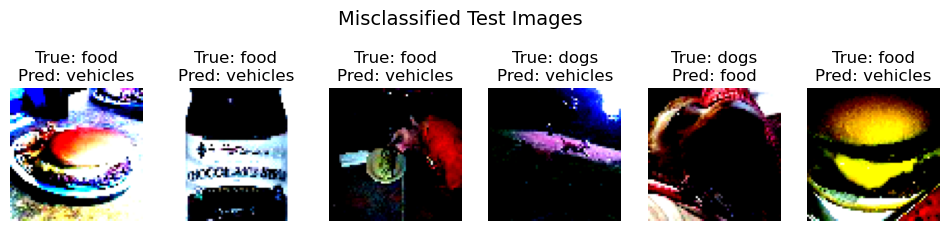

In [ ]:
show_misclassified_images(vgg_xavier, test_loader, device=device)

------------------------- Xavier+Adam+32 ---------------------------------------------

In [ ]:
optimizer_xavier_adam_32 = optim.Adam(vgg_xavier.parameters(), lr=0.001, weight_decay=1e-4)

print("\n Training VGG-16 (Xavier Initialization + Adam + Batch Size 32)...")
history_xavier_adam_32 = train_vgg16(vgg_xavier, train_loaders[32], val_loader, optimizer_xavier_adam_32, criterion, epochs=5, device=device)


 Training VGG-16 (Xavier Initialization + Adam + Batch Size 32)...
Epoch [1/5] | Train Loss: 0.8721 | Train Acc: 58.33% | Val Loss: 0.4740 | Val Acc: 80.73%
Epoch [2/5] | Train Loss: 0.5097 | Train Acc: 80.24% | Val Loss: 0.3931 | Val Acc: 85.67%
Epoch [3/5] | Train Loss: 0.4079 | Train Acc: 85.08% | Val Loss: 0.3151 | Val Acc: 88.57%
Epoch [4/5] | Train Loss: 0.3578 | Train Acc: 87.23% | Val Loss: 0.3546 | Val Acc: 88.00%
Epoch [5/5] | Train Loss: 0.3356 | Train Acc: 87.97% | Val Loss: 0.4516 | Val Acc: 85.70%


In [ ]:
torch.save(vgg_xavier.state_dict(), "vgg16_xavier_adam_32.pth")
print("\n Model weights saved as vgg16_xavier_adam_32.pth")


 Model weights saved as vgg16_xavier_adam_32.pth



 Test Accuracy: 86.00%


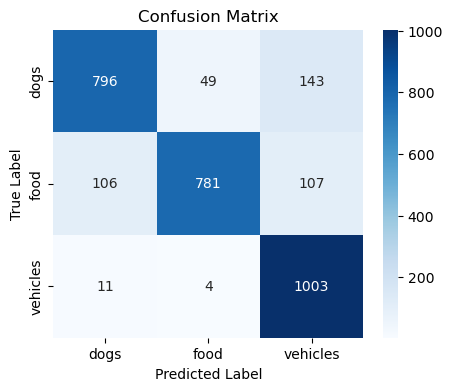


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.87      0.81      0.84       988
        food       0.94      0.79      0.85       994
    vehicles       0.80      0.99      0.88      1018

    accuracy                           0.86      3000
   macro avg       0.87      0.86      0.86      3000
weighted avg       0.87      0.86      0.86      3000



In [ ]:
evaluate_model(vgg_xavier, test_loader, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.695136..1.9876019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.1813548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.780822..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].


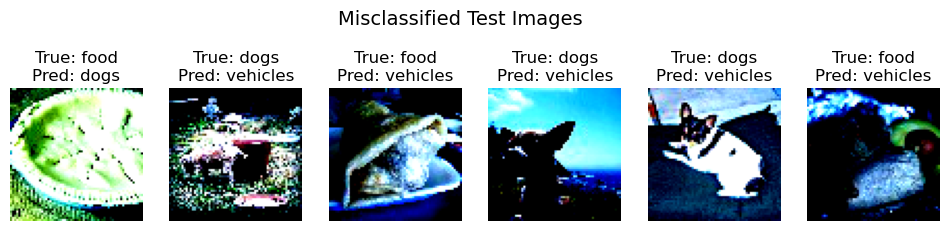

In [ ]:
show_misclassified_images(vgg_xavier, test_loader, device=device)

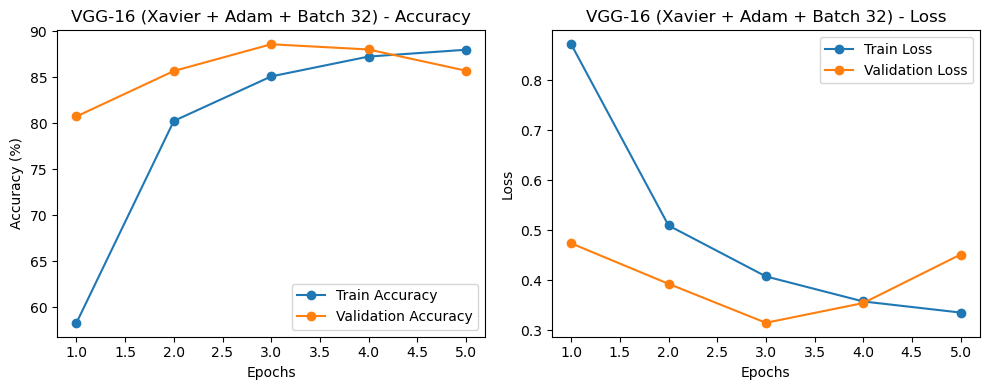

In [ ]:
def plot_training_curves(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_xavier_adam_32, title="VGG-16 (Xavier + Adam + Batch 32)")


 ---------------------- Xavier+AdamW+32 ---------------------------------

In [ ]:
optimizer_xavier_adamw_32 = optim.AdamW(vgg_xavier.parameters(), lr=0.001, weight_decay=1e-4)

print("\n Training VGG-16 (Xavier Initialization + AdamW + Batch Size 32)...")
history_xavier_adamw_32 = train_vgg16(vgg_xavier, train_loaders[32], val_loader, optimizer_xavier_adamw_32, criterion, epochs=5, device=device)




 Training VGG-16 (Xavier Initialization + AdamW + Batch Size 32)...
Epoch [1/5] | Train Loss: 0.3044 | Train Acc: 89.22% | Val Loss: 0.2364 | Val Acc: 90.97%
Epoch [2/5] | Train Loss: 0.3080 | Train Acc: 89.01% | Val Loss: 0.2466 | Val Acc: 91.07%
Epoch [3/5] | Train Loss: 0.2825 | Train Acc: 89.80% | Val Loss: 0.2256 | Val Acc: 91.83%
Epoch [4/5] | Train Loss: 0.2703 | Train Acc: 90.42% | Val Loss: 0.2486 | Val Acc: 90.80%
Epoch [5/5] | Train Loss: 0.2682 | Train Acc: 90.55% | Val Loss: 0.2179 | Val Acc: 92.80%


In [ ]:
torch.save(vgg_xavier.state_dict(), "vgg16_xavier_adamw_32.pth")
print("\n Model weights saved as vgg16_xavier_adamw_32.pth")


 Model weights saved as vgg16_xavier_adamw_32.pth



 Test Accuracy: 92.20%


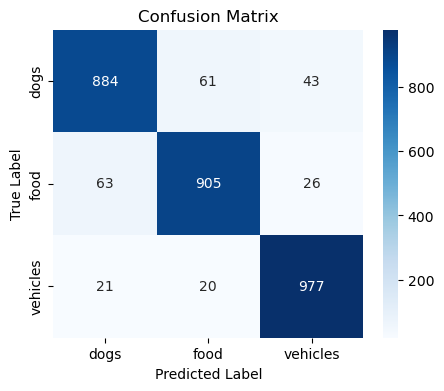


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.91      0.89      0.90       988
        food       0.92      0.91      0.91       994
    vehicles       0.93      0.96      0.95      1018

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [ ]:
evaluate_model(vgg_xavier, test_loader, device=device)


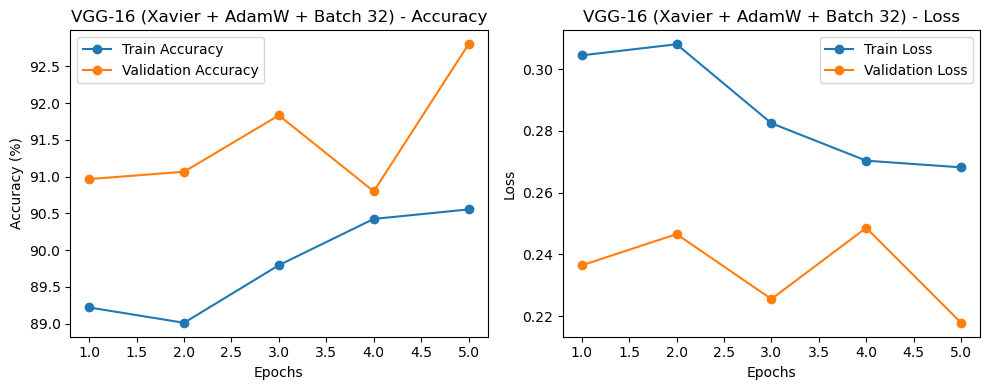

In [ ]:
def plot_training_curves(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_xavier_adamw_32, title="VGG-16 (Xavier + AdamW + Batch 32)")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.780822..1.99731].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..1.8840518].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4666395..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8236651..2.2238266].


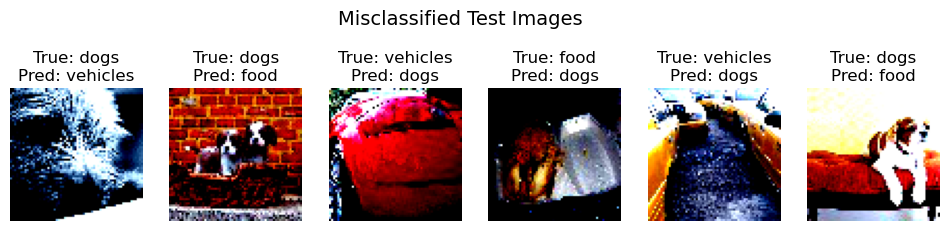

In [ ]:
show_misclassified_images(vgg_xavier, test_loader, device=device)

So far after trying 3 different optimizers for coinstant weight intilkization and batch size we canb see that AdamW gave best performance so lets finalize this optimizer
Now lets see with increased 64 batch size and see wether it beets the 32 batch size
Xavier+AdamW+64

--------------------------- Xavier + AdamW + 64 ------------------------------

In [ ]:
optimizer_xavier_adamw_64 = optim.AdamW(vgg_xavier.parameters(), lr=0.001, weight_decay=1e-4)
print("\n Training VGG-16 (Xavier Initialization + AdamW + Batch Size 64)...")
history_xavier_adamw_64 = train_vgg16(vgg_xavier, train_loaders[64], val_loader, optimizer_xavier_adamw_64, criterion, epochs=5, device=device)



 Training VGG-16 (Xavier Initialization + AdamW + Batch Size 64)...
Epoch [1/5] | Train Loss: 0.2360 | Train Acc: 91.77% | Val Loss: 0.2247 | Val Acc: 92.10%
Epoch [2/5] | Train Loss: 0.2293 | Train Acc: 91.79% | Val Loss: 0.3234 | Val Acc: 89.70%
Epoch [3/5] | Train Loss: 0.3379 | Train Acc: 89.68% | Val Loss: 0.2893 | Val Acc: 89.23%
Epoch [4/5] | Train Loss: 0.2962 | Train Acc: 89.06% | Val Loss: 0.2199 | Val Acc: 92.10%
Epoch [5/5] | Train Loss: 0.2566 | Train Acc: 91.00% | Val Loss: 0.2277 | Val Acc: 92.67%


In [ ]:
torch.save(vgg_xavier.state_dict(), "vgg16_xavier_adamw_64.pth")
print("\n Model weights saved as vgg16_xavier_adamw_64.pth")


 Model weights saved as vgg16_xavier_adamw_64.pth



 Test Accuracy: 92.43%


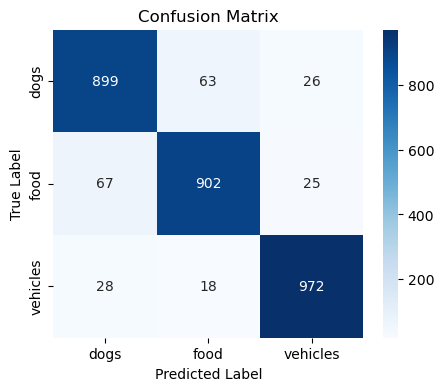


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.90      0.91      0.91       988
        food       0.92      0.91      0.91       994
    vehicles       0.95      0.95      0.95      1018

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [ ]:
evaluate_model(vgg_xavier, test_loader, device=device)

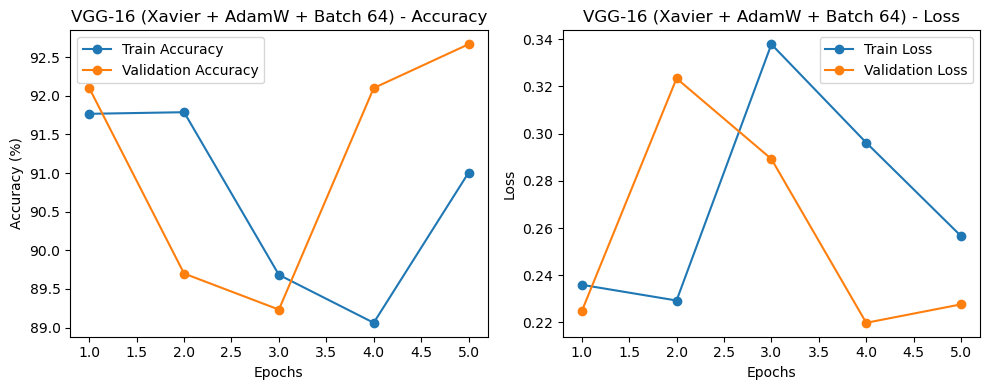

In [ ]:
def plot_training_curves(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_xavier_adamw_64, title="VGG-16 (Xavier + AdamW + Batch 64)")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6665739..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6665739..2.0680964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].


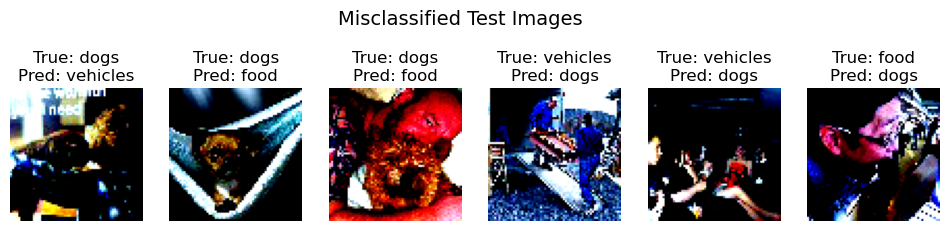

In [ ]:
show_misclassified_images(vgg_xavier, test_loader, device=device)


We can see that batch 64 gave little better results with the same setup when compared with the 32 but the traning is very stable compared to the 32 batch size so lets finalize the batch size too that is 32
He+AdamW+32

--------------------------- he INITIALIZATION + Adam W + BATCH SIZE 32 --------------------------------

In [ ]:
optimizer_he_adamw_32 = optim.AdamW(vgg_he.parameters(), lr=0.001, weight_decay=1e-4)
print("\n Training VGG-16 (he Initialization + AdamW + Batch Size 32)...")
history_he_adamw_32 = train_vgg16(vgg_he, train_loaders[32], val_loader, optimizer_he_adamw_32, criterion, epochs=5, device=device)


 Training VGG-16 (he Initialization + AdamW + Batch Size 32)...
Epoch [1/5] | Train Loss: 1.2638 | Train Acc: 57.64% | Val Loss: 0.4586 | Val Acc: 82.27%
Epoch [2/5] | Train Loss: 0.4989 | Train Acc: 80.90% | Val Loss: 0.3735 | Val Acc: 85.70%
Epoch [3/5] | Train Loss: 0.4125 | Train Acc: 84.78% | Val Loss: 0.3564 | Val Acc: 87.40%
Epoch [4/5] | Train Loss: 0.3604 | Train Acc: 86.98% | Val Loss: 0.3254 | Val Acc: 88.27%
Epoch [5/5] | Train Loss: 0.3466 | Train Acc: 87.68% | Val Loss: 0.2846 | Val Acc: 90.20%


In [ ]:
torch.save(vgg_he.state_dict(), "vgg16_he_adamw_32.pth")
print("\n Model weights saved as vgg16_he_adamw_32.pth")


 Model weights saved as vgg16_he_adamw_32.pth



 Test Accuracy: 90.23%


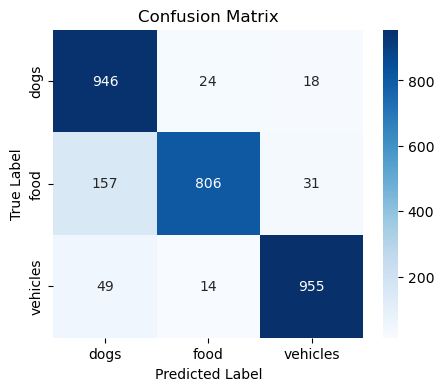


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.82      0.96      0.88       988
        food       0.95      0.81      0.88       994
    vehicles       0.95      0.94      0.94      1018

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



In [ ]:
evaluate_model(vgg_he, test_loader, device=device)


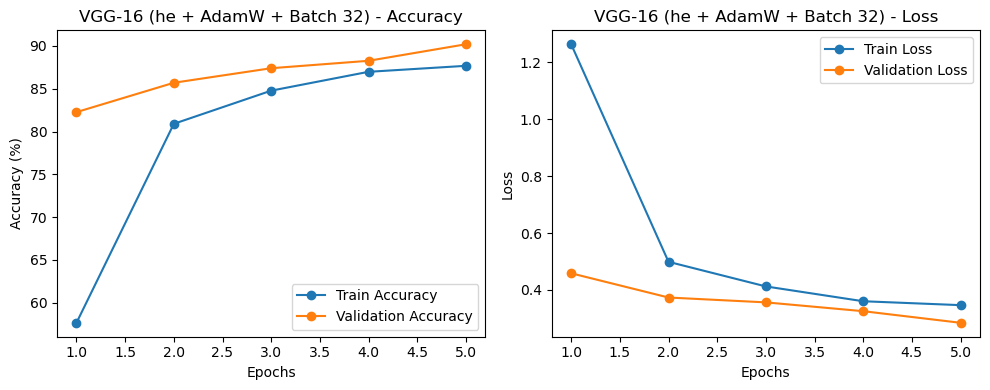

In [ ]:
def plot_training_curves(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_he_adamw_32, title="VGG-16 (he + AdamW + Batch 32)")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.0680964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8093841..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.695136..1.9876019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.2238266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..2.0397818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379462..1.7849507].


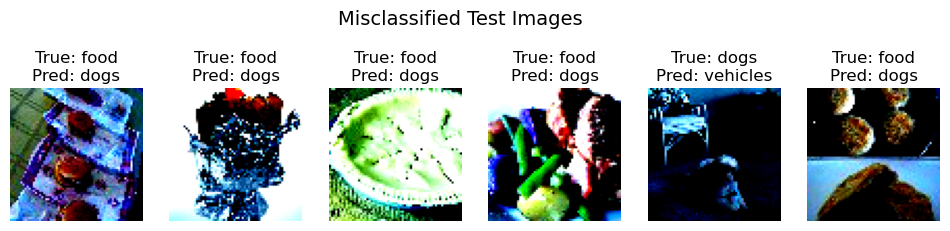

In [ ]:
show_misclassified_images(vgg_he, test_loader, device=device)


For regularization techniques we had considered droput regularization i.e, we had used dropout layers p=0.5 and used image augumentation of flip 15 degrees so till now we found them effeicent so we use theseregularization techniques for resent aswell

In [ ]:
model = VGG16(num_classes=3)

checkpoint_path = "vgg16_xavier_adamw_32.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)

print("Model weights loaded successfully!")


Model weights loaded successfully!


In [ ]:
history_dropout = train_vgg16(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)


Epoch [1/5] | Train Loss: 0.2246 | Train Acc: 92.11% | Val Loss: 0.2056 | Val Acc: 92.47%
Epoch [2/5] | Train Loss: 0.2253 | Train Acc: 92.15% | Val Loss: 0.2056 | Val Acc: 92.47%
Epoch [3/5] | Train Loss: 0.2254 | Train Acc: 92.05% | Val Loss: 0.2056 | Val Acc: 92.47%
Epoch [4/5] | Train Loss: 0.2233 | Train Acc: 92.27% | Val Loss: 0.2056 | Val Acc: 92.47%
Epoch [5/5] | Train Loss: 0.2248 | Train Acc: 92.22% | Val Loss: 0.2056 | Val Acc: 92.47%


Lets use the dropout regulrizations here as we are using o.5 from start lets see with its edges i.e 0.3 and 0.7 to understand the better performance

In [ ]:
pip install tensorboard


  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 37.0 MB/s eta 0:00:00 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
history_xavier_adamw_32=history_dropout


In [ ]:

writer = SummaryWriter(log_dir="runs/vgg16_xavier_adamw")

for epoch in range(len(history_xavier_adamw_32["train_acc"])):
    writer.add_scalar("Loss/Train", history_xavier_adamw_32["train_loss"][epoch], epoch + 1)
    writer.add_scalar("Loss/Validation", history_xavier_adamw_32["val_loss"][epoch], epoch + 1)
    writer.add_scalar("Accuracy/Train", history_xavier_adamw_32["train_acc"][epoch], epoch + 1)
    writer.add_scalar("Accuracy/Validation", history_xavier_adamw_32["val_acc"][epoch], epoch + 1)



writer.close()

print("\nTraining Metrics Logged in TensorBoard.")



Training Metrics Logged in TensorBoard.


## Step 3: Implementing ResNet

1. Implement residual blocks of ResNet.

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = (
            nn.Identity() if stride == 1 and in_channels == out_channels else
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
input_tensor = torch.randn(1, 64, 32, 32)
block_no_downsample = ResidualBlock(64, 64, stride=1)
output = block_no_downsample(input_tensor)
print(f"Output shape (no downsample): {output.shape}")

block_downsample = ResidualBlock(64, 128, stride=2)
output_downsample = block_downsample(input_tensor)
print(f"Output shape (with downsample): {output_downsample.shape}")


Output shape (no downsample): torch.Size([1, 64, 32, 32])
Output shape (with downsample): torch.Size([1, 128, 16, 16])


2. Assemble the ResNet-18 architecture.

In [ ]:
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride=stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
model = ResNet18(num_classes=3)

input_tensor = torch.randn(1, 3, 64, 64)
output = model(input_tensor)

print(f"Output shape: {output.shape}")


Output shape: torch.Size([1, 3])


3. Train the ResNet-18 model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

In [ ]:
import zipfile
import os

dataset_path = "cnn_dataset"

print(f"Dataset is : {dataset_path}")

Dataset is : cnn_dataset


 Data Preparation

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5047, 0.4501, 0.3840], std=[0.2746, 0.2668, 0.2770])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5047, 0.4501, 0.3840], std=[0.2746, 0.2668, 0.2770])
])

In [ ]:
full_dataset = ImageFolder(root=dataset_path)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset = Subset(ImageFolder(root=dataset_path, transform=train_transforms), train_dataset.indices)
val_dataset = Subset(ImageFolder(root=dataset_path, transform=test_transforms), val_dataset.indices)
test_dataset = Subset(ImageFolder(root=dataset_path, transform=test_transforms), test_dataset.indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


ResNet-18 Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Training Setup

In [ ]:
model = ResNet18(num_classes=3)

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device="cuda"):
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train
        train_loss = running_loss / total_train

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = 100 * correct_val / total_val
        val_loss /= total_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history





In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training Configuration

In [ ]:
history_resnet = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)


Epoch [1/5] | Train Loss: 0.4740 | Train Acc: 81.58% | Val Loss: 0.3498 | Val Acc: 85.80%
Epoch [2/5] | Train Loss: 0.3529 | Train Acc: 86.70% | Val Loss: 0.3362 | Val Acc: 87.33%
Epoch [3/5] | Train Loss: 0.3136 | Train Acc: 88.32% | Val Loss: 0.2972 | Val Acc: 88.63%
Epoch [4/5] | Train Loss: 0.2847 | Train Acc: 89.47% | Val Loss: 0.2659 | Val Acc: 89.80%
Epoch [5/5] | Train Loss: 0.2634 | Train Acc: 90.19% | Val Loss: 0.2433 | Val Acc: 91.23%


Plot Accuracy and Loss Curves

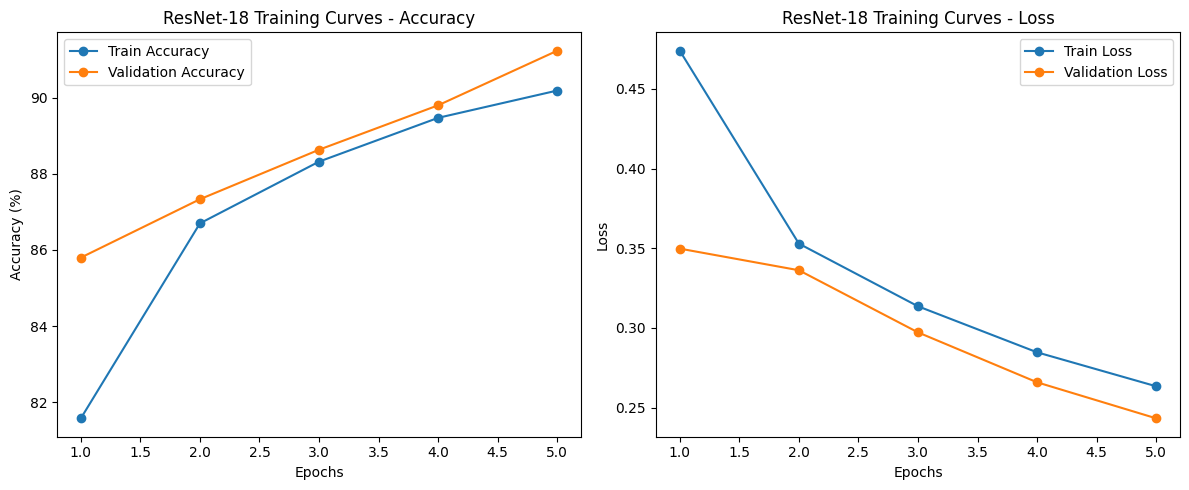

In [ ]:
def plot_training_curves(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history_resnet, title="ResNet-18 Training Curves")



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=3, dropout_prob=0.5):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


model = ResNet18(num_classes=3, dropout_prob=0.5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Xavier + SGD + Batch 32 for ResNet-18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

In [ ]:
def initialize_weights_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

model_sgd_32 = ResNet18(num_classes=3)
initialize_weights_xavier(model_sgd_32)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_sgd_32 = optim.SGD(model_sgd_32.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
history_sgd_32 = train_model(model_sgd_32, train_loader, val_loader, optimizer_sgd_32, criterion, epochs=5, device=device)

Epoch [1/5] | Train Loss: 0.6150 | Train Acc: 76.55% | Val Loss: 0.4005 | Val Acc: 84.80%
Epoch [2/5] | Train Loss: 0.4125 | Train Acc: 84.21% | Val Loss: 0.3275 | Val Acc: 87.40%
Epoch [3/5] | Train Loss: 0.3537 | Train Acc: 86.26% | Val Loss: 0.3240 | Val Acc: 88.07%
Epoch [4/5] | Train Loss: 0.3151 | Train Acc: 87.95% | Val Loss: 0.2939 | Val Acc: 88.47%
Epoch [5/5] | Train Loss: 0.2887 | Train Acc: 89.12% | Val Loss: 0.3686 | Val Acc: 86.50%


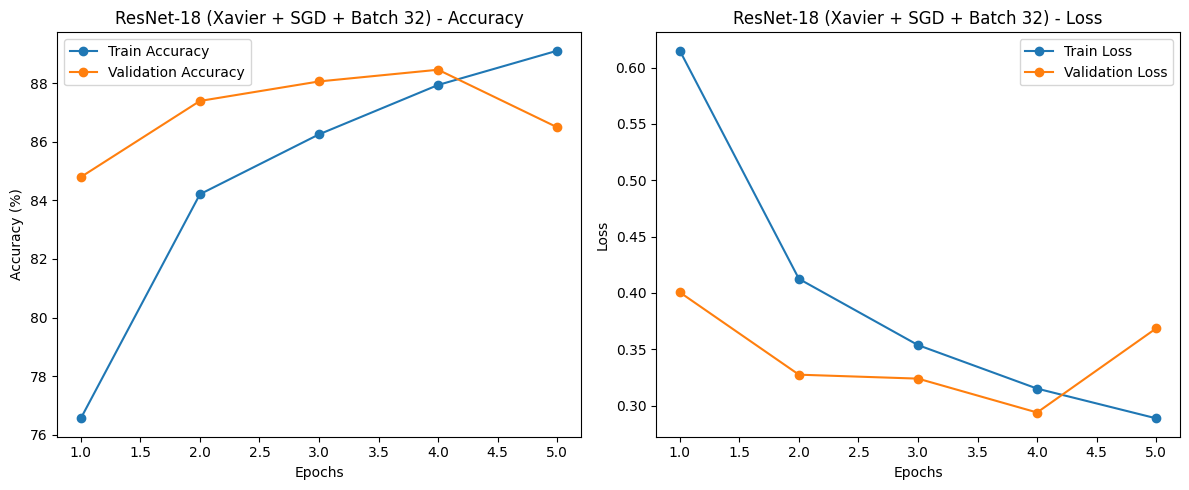

In [ ]:
plot_training_curves(history_sgd_32, title="ResNet-18 (Xavier + SGD + Batch 32)")


In [ ]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [ ]:
all_labels, all_preds = evaluate_model(model_sgd_32, test_loader, device=device)
test_acc = accuracy_score(all_labels, all_preds) * 100
print(f"\n Test Accuracy: {test_acc:.2f}%")


 Test Accuracy: 90.23%


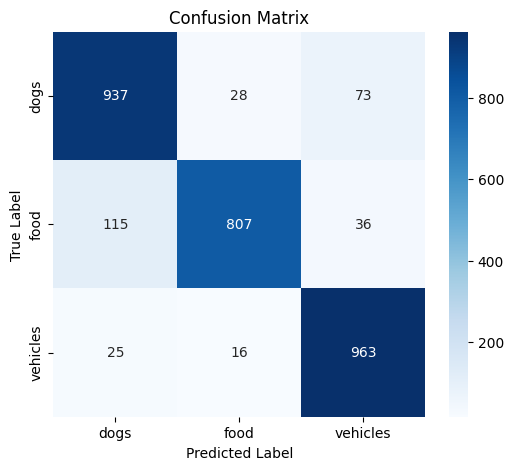

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.dataset.classes, yticklabels=test_loader.dataset.dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.dataset.classes))



 Classification Report:
              precision    recall  f1-score   support

        dogs       0.87      0.90      0.89      1038
        food       0.95      0.84      0.89       958
    vehicles       0.90      0.96      0.93      1004

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



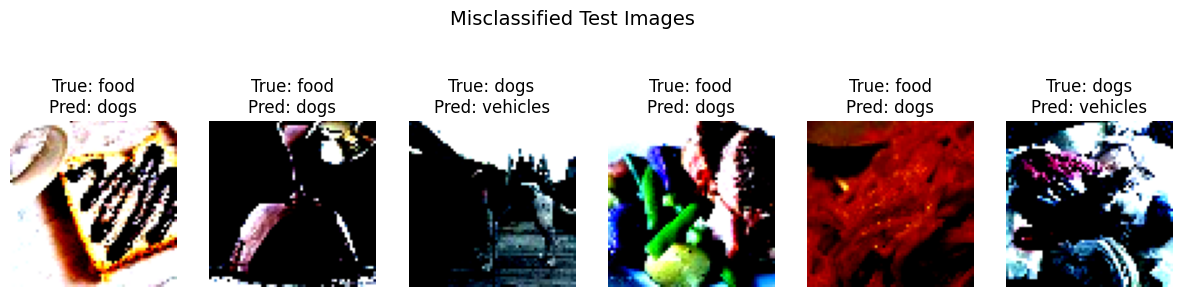

In [ ]:
def show_misclassified_images(model, test_loader, device="cuda", num_images=6):
    model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

    misclassified_samples = random.sample(misclassified, min(num_images, len(misclassified)))
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(15, 4))
    for i, (img, true_label, pred_label) in enumerate(misclassified_samples):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[pred_label]}")
    plt.suptitle("Misclassified Test Images", fontsize=14)
    plt.show()

show_misclassified_images(model_sgd_32, test_loader, device=device)


6. Save the weights of the trained network.

In [ ]:

torch.save(model_sgd_32.state_dict(), "resnet18_xavier_sgd_32.pth")
print("\n Model weights saved as resnet18_xavier_sgd_32.pth")



 Model weights saved as resnet18_xavier_sgd_32.pth


Xavier + Adam + Batch 32 for ResNet-18

In [ ]:
model_adam_32 = ResNet18(num_classes=3)
initialize_weights_xavier(model_adam_32)  


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_adam_32 = optim.Adam(model_adam_32.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
history_adam_32 = train_model(
    model_adam_32,
    train_loader,
    val_loader,
    optimizer_adam_32,
    criterion,
    epochs=5,
    device=device
)


Epoch [1/5] | Train Loss: 0.5658 | Train Acc: 78.75% | Val Loss: 0.3709 | Val Acc: 85.83%
Epoch [2/5] | Train Loss: 0.4109 | Train Acc: 84.77% | Val Loss: 0.3517 | Val Acc: 87.33%
Epoch [3/5] | Train Loss: 0.3599 | Train Acc: 86.54% | Val Loss: 0.3101 | Val Acc: 88.40%
Epoch [4/5] | Train Loss: 0.3247 | Train Acc: 87.98% | Val Loss: 0.3334 | Val Acc: 87.07%
Epoch [5/5] | Train Loss: 0.2962 | Train Acc: 89.22% | Val Loss: 0.2609 | Val Acc: 90.27%


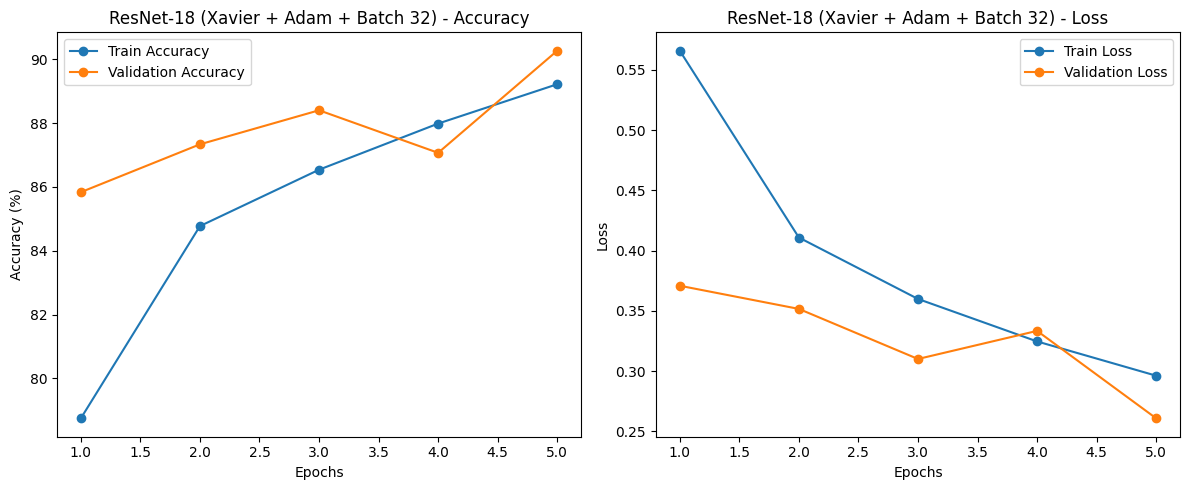

In [ ]:
plot_training_curves(history_adam_32, title="ResNet-18 (Xavier + Adam + Batch 32)")



Test Accuracy: 90.60%


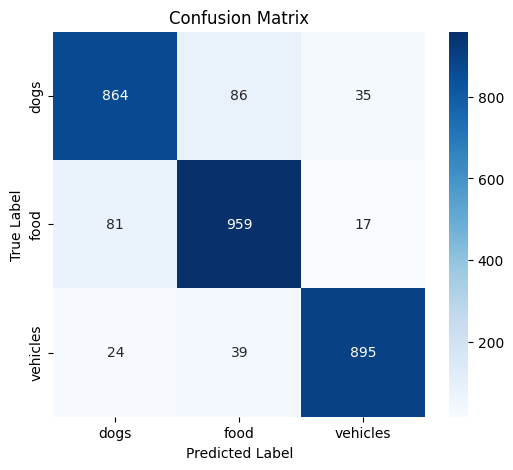


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.89      0.88      0.88       985
        food       0.88      0.91      0.90      1057
    vehicles       0.95      0.93      0.94       958

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    test_acc = accuracy_score(all_labels, all_preds) * 100
    print(f"\nTest Accuracy: {test_acc:.2f}%")

    #  Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_loader.dataset.dataset.classes,
                yticklabels=test_loader.dataset.dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.dataset.classes))
    
evaluate_model(model_adam_32, test_loader, device=device)


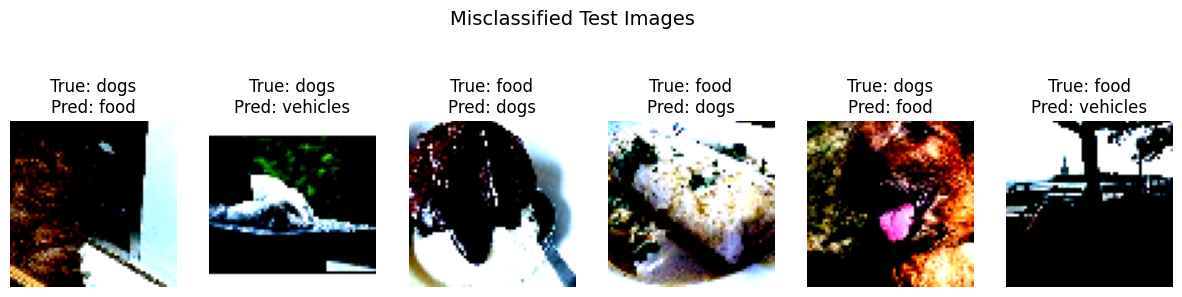

In [ ]:
import random

def show_misclassified_images(model, test_loader, device="cuda", num_images=6):
    model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

    if len(misclassified) == 0:
        print("No misclassified images found!")
        return

    misclassified_samples = random.sample(misclassified, min(num_images, len(misclassified)))

    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(15, 4))
    for i, (img, true_label, pred_label) in enumerate(misclassified_samples):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[pred_label]}")

    plt.suptitle("Misclassified Test Images", fontsize=14)
    plt.show()

show_misclassified_images(model_adam_32, test_loader, device=device)


In [ ]:
model_save_path = "resnet18_xavier_adam_32.pth"
torch.save(model_adam_32.state_dict(), model_save_path)
print(f"\  Model weights saved as: {model_save_path}")


\  Model weights saved as: resnet18_xavier_adam_32.pth


Xavier + AdamW + Batch 32

In [ ]:
model_adamw_32 = ResNet18(num_classes=3)
initialize_weights_xavier(model_adamw_32)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_adamw_32 = optim.AdamW(model_adamw_32.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
history_adamw_32 = train_model(
    model_adamw_32,
    train_loader,
    val_loader,
    optimizer_adamw_32,
    criterion,
    epochs=5,
    device=device
)

Epoch [1/5] | Train Loss: 0.5719 | Train Acc: 78.49% | Val Loss: 0.3861 | Val Acc: 85.63%
Epoch [2/5] | Train Loss: 0.4211 | Train Acc: 84.05% | Val Loss: 0.3615 | Val Acc: 86.03%
Epoch [3/5] | Train Loss: 0.3583 | Train Acc: 86.86% | Val Loss: 0.3840 | Val Acc: 85.53%
Epoch [4/5] | Train Loss: 0.3135 | Train Acc: 88.33% | Val Loss: 0.4582 | Val Acc: 83.37%
Epoch [5/5] | Train Loss: 0.3128 | Train Acc: 88.64% | Val Loss: 0.3171 | Val Acc: 89.43%


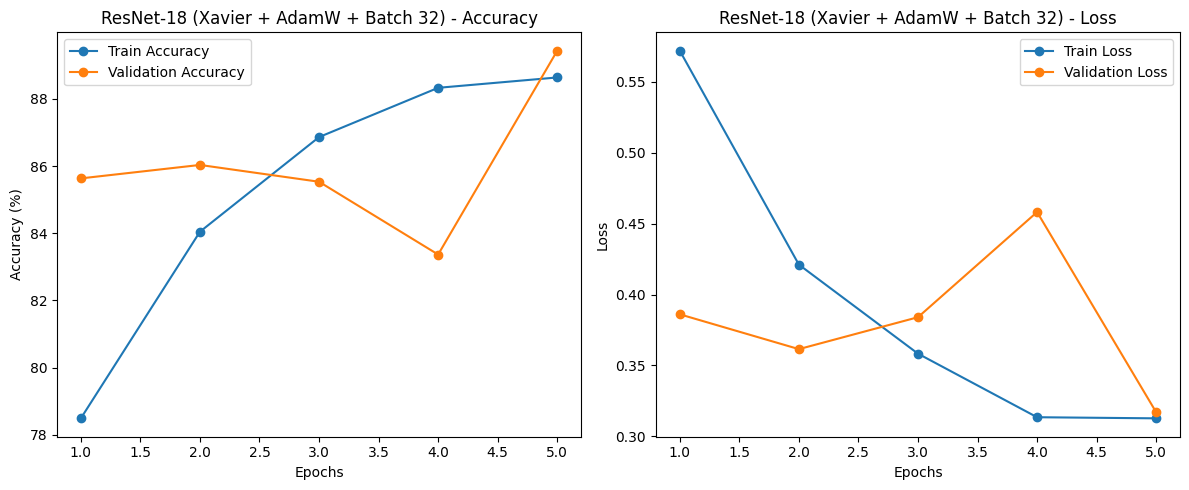

In [ ]:
plot_training_curves(history_adamw_32, title="ResNet-18 (Xavier + AdamW + Batch 32)")



Test Accuracy: 89.43%


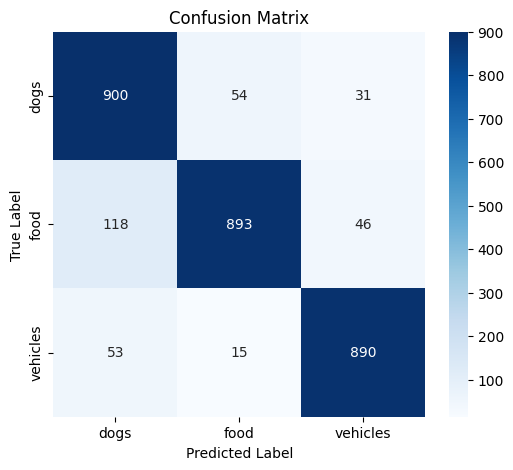


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.84      0.91      0.88       985
        food       0.93      0.84      0.88      1057
    vehicles       0.92      0.93      0.92       958

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.89      3000
weighted avg       0.90      0.89      0.89      3000



In [ ]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds) * 100
    print(f"\nTest Accuracy: {test_acc:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_loader.dataset.dataset.classes,
                yticklabels=test_loader.dataset.dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.dataset.classes))

evaluate_model(model_adamw_32, test_loader, device=device)


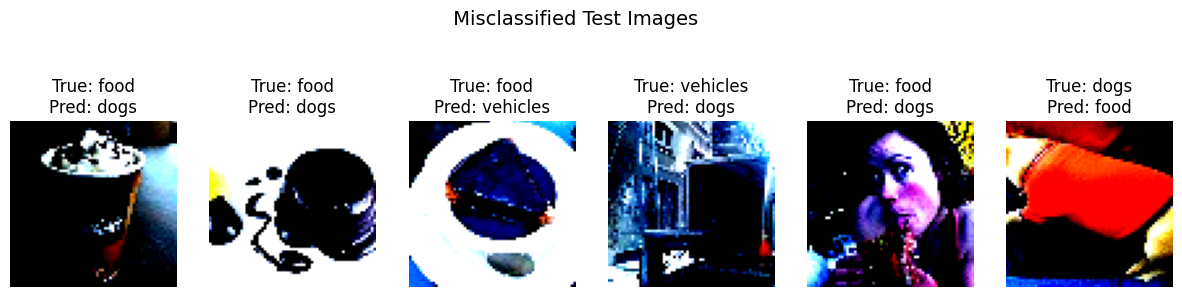

In [ ]:
import random

def show_misclassified_images(model, test_loader, device="cuda", num_images=6):
    model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

    if len(misclassified) == 0:
        print("No misclassified images found!")
        return

    misclassified_samples = random.sample(misclassified, min(num_images, len(misclassified)))

    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(15, 4))
    for i, (img, true_label, pred_label) in enumerate(misclassified_samples):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[pred_label]}")

    plt.suptitle(" Misclassified Test Images", fontsize=14)
    plt.show()

show_misclassified_images(model_adamw_32, test_loader, device=device)


In [ ]:

model_save_path = "resnet18_xavier_adamw_32.pth"
torch.save(model_adamw_32.state_dict(), model_save_path)
print(f"\nModel weights saved as: {model_save_path}")



Model weights saved as: resnet18_xavier_adamw_32.pth


Xavier + AdamW + Batch 64

In [ ]:
model_adamw_64 = ResNet18(num_classes=3)
initialize_weights_xavier(model_adamw_64)

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer_adamw_64 = optim.AdamW(model_adamw_64.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
train_loader_64 = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader_64 = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader_64 = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
history_adamw_64 = train_model(
    model_adamw_64,
    train_loader_64,
    val_loader_64,
    optimizer_adamw_64,
    criterion,
    epochs=5,
    device=device
)

Epoch [1/5] | Train Loss: 0.5417 | Train Acc: 79.53% | Val Loss: 0.3863 | Val Acc: 86.50%
Epoch [2/5] | Train Loss: 0.3691 | Train Acc: 86.23% | Val Loss: 0.5147 | Val Acc: 82.00%
Epoch [3/5] | Train Loss: 0.3240 | Train Acc: 87.73% | Val Loss: 0.2979 | Val Acc: 89.10%
Epoch [4/5] | Train Loss: 0.2867 | Train Acc: 89.25% | Val Loss: 0.2572 | Val Acc: 90.03%
Epoch [5/5] | Train Loss: 0.2558 | Train Acc: 90.58% | Val Loss: 0.2803 | Val Acc: 89.97%


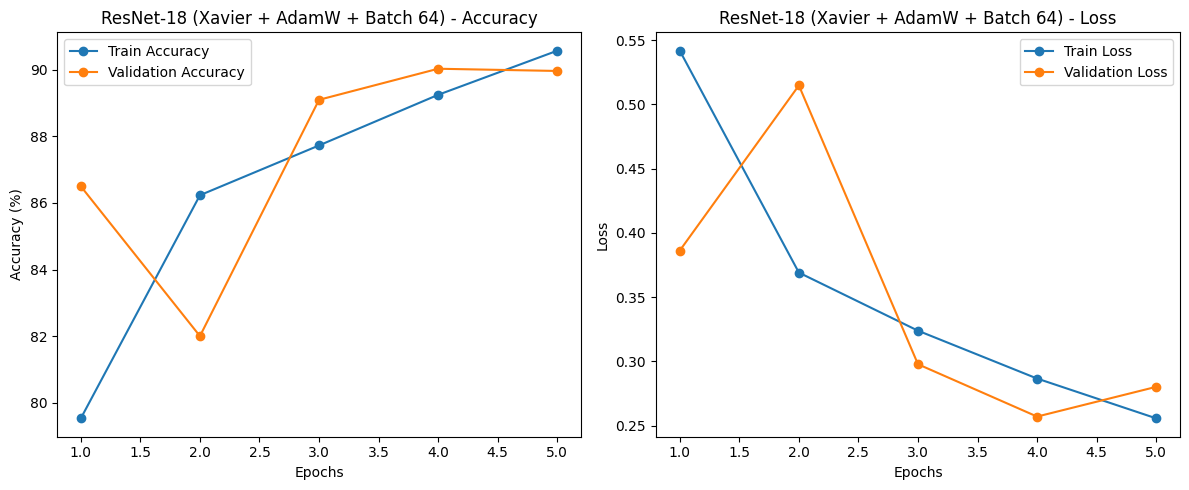

In [ ]:
plot_training_curves(history_adamw_64, title="ResNet-18 (Xavier + AdamW + Batch 64)")


 Test Accuracy: 90.33%


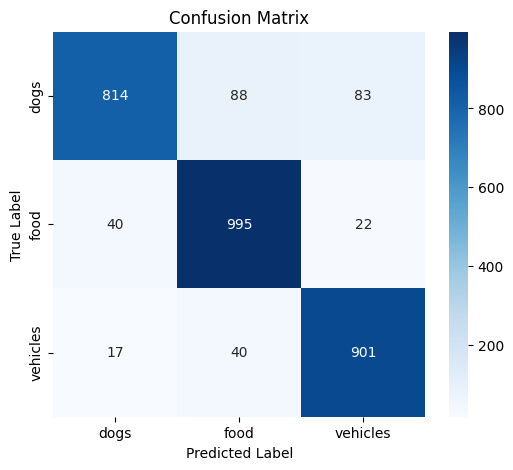


 Classification Report:
              precision    recall  f1-score   support

        dogs       0.93      0.83      0.88       985
        food       0.89      0.94      0.91      1057
    vehicles       0.90      0.94      0.92       958

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



In [ ]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Test Accuracy
    test_acc = accuracy_score(all_labels, all_preds) * 100
    print(f"\n Test Accuracy: {test_acc:.2f}%")

    #  Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_loader.dataset.dataset.classes,
                yticklabels=test_loader.dataset.dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    #  Classification Report
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.dataset.classes))

evaluate_model(model_adamw_64, test_loader_64, device=device)

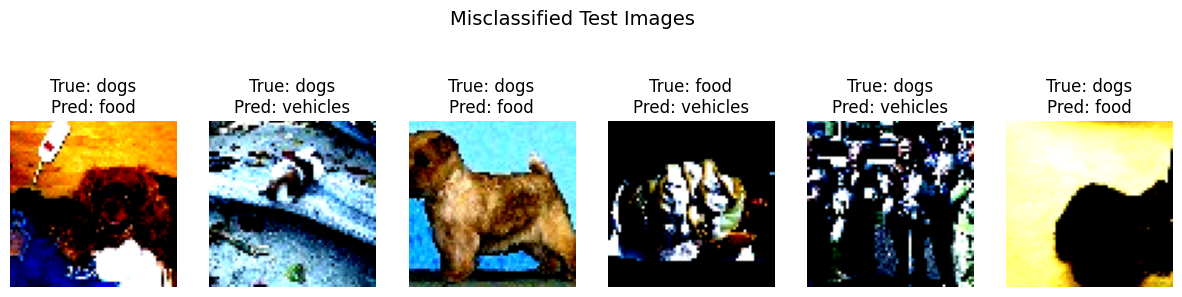

In [ ]:
def show_misclassified_images(model, test_loader, device="cuda", num_images=6):
    model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))

    if not misclassified:
        print("\n No misclassified images found!")
        return

    misclassified_samples = random.sample(misclassified, min(num_images, len(misclassified)))
    fig, axes = plt.subplots(1, len(misclassified_samples), figsize=(15, 4))

    for i, (img, true_label, pred_label) in enumerate(misclassified_samples):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {test_loader.dataset.dataset.classes[true_label]}\nPred: {test_loader.dataset.dataset.classes[pred_label]}")

    plt.suptitle("Misclassified Test Images", fontsize=14)
    plt.show()

show_misclassified_images(model_adamw_64, test_loader_64, device=device)


In [ ]:
model = ResNet18(num_classes=3)

checkpoint_path = "resnet18_xavier_adam_32.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.to(device)
print("Model weights loaded successfully!")


Model weights loaded successfully!


In [ ]:
history_adam_32 = train_model(
    model,
    train_loader,
    val_loader,
    optimizer_adam_32,
    criterion,
    epochs=5,
    device=device
)

Epoch [1/5] | Train Loss: 0.2743 | Train Acc: 89.75% | Val Loss: 0.2251 | Val Acc: 91.70%
Epoch [2/5] | Train Loss: 0.2779 | Train Acc: 89.80% | Val Loss: 0.2243 | Val Acc: 91.53%
Epoch [3/5] | Train Loss: 0.2751 | Train Acc: 90.07% | Val Loss: 0.2243 | Val Acc: 91.97%
Epoch [4/5] | Train Loss: 0.2742 | Train Acc: 90.13% | Val Loss: 0.2226 | Val Acc: 91.63%
Epoch [5/5] | Train Loss: 0.2739 | Train Acc: 90.08% | Val Loss: 0.2208 | Val Acc: 92.07%


In [ ]:

model_save_path = "resnet18_xavier_adamw_64.pth"
torch.save(model_adamw_64.state_dict(), model_save_path)
print(f"\n Model weights saved as: {model_save_path}")


 Model weights saved as: resnet18_xavier_adamw_64.pth


In [ ]:
history_resnet18=history_adam_32

In [ ]:
writer = SummaryWriter(log_dir="runs/resnet18_xavier_adamw")
for epoch in range(len(history_resnet18["train_acc"])):
    writer.add_scalar("Loss/Train", history_resnet18["train_loss"][epoch], epoch + 1)
    writer.add_scalar("Loss/Validation", history_resnet18["val_loss"][epoch], epoch + 1)
    writer.add_scalar("Accuracy/Train", history_resnet18["train_acc"][epoch], epoch + 1)
    writer.add_scalar("Accuracy/Validation", history_resnet18["val_acc"][epoch], epoch + 1)

writer.close()

print("\nTraining Metrics Logged in TensorBoard.")


Training Metrics Logged in TensorBoard.


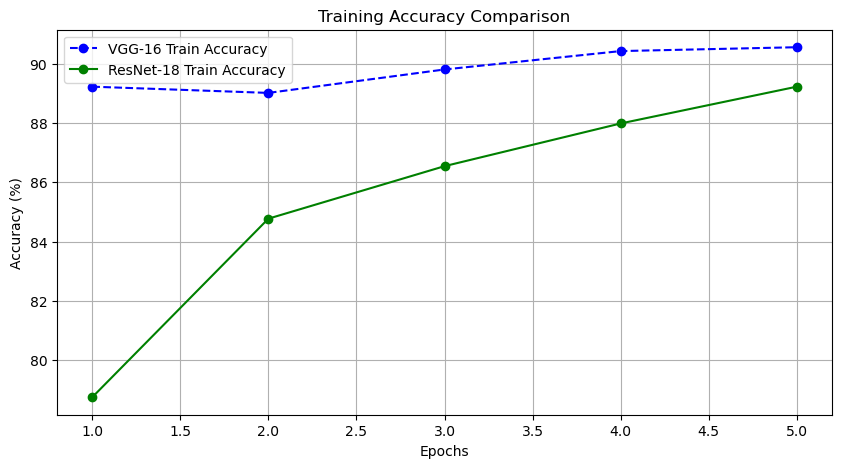

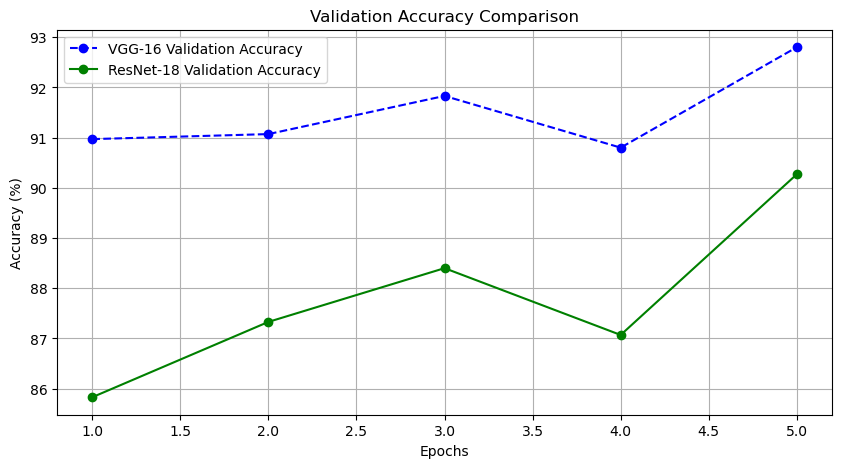

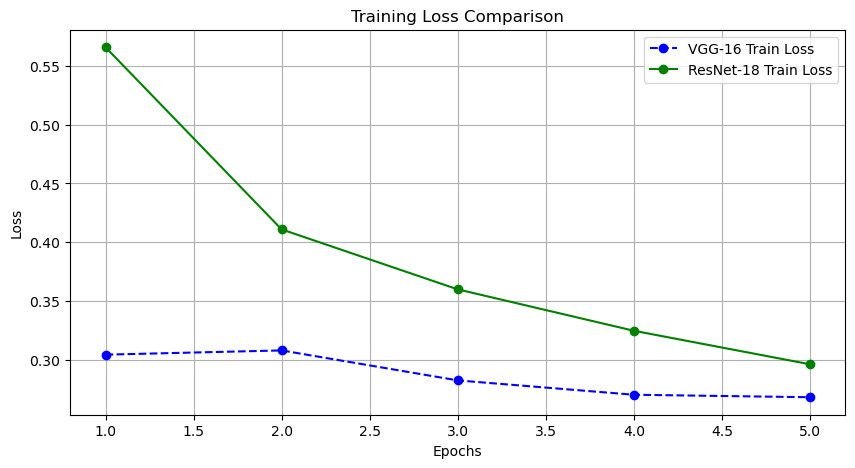

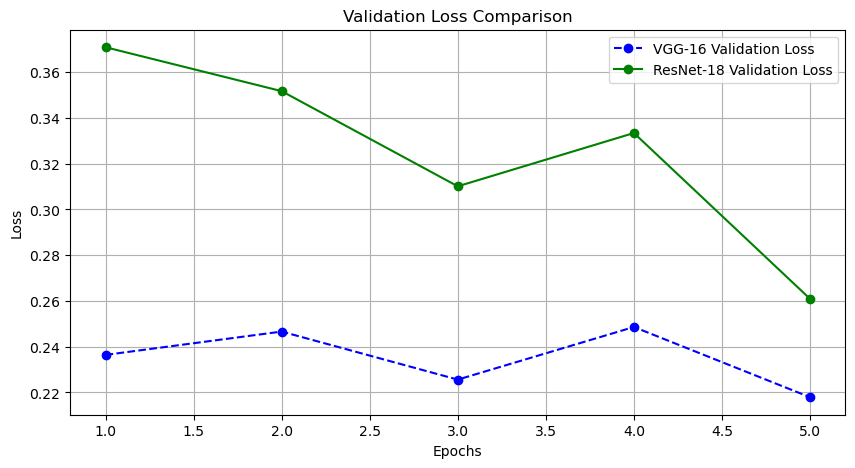

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)  

history_vgg16 = {
    "train_acc": [89.22, 89.01, 89.80, 90.42, 90.55],
    "val_acc": [90.97, 91.07, 91.83, 90.80, 92.80],
    "train_loss": [0.3044, 0.3080, 0.2825, 0.2703, 0.2682],
    "val_loss": [0.2364, 0.2466, 0.2256, 0.2486, 0.2179]
}

history_resnet18 = {
    "train_acc": [78.75, 84.77, 86.54, 87.98, 89.22],
    "val_acc": [85.83, 87.33, 88.40, 87.07, 90.27],
    "train_loss": [0.5658, 0.4109, 0.3599, 0.3247, 0.2962],
    "val_loss": [0.3709, 0.3517, 0.3101, 0.3334, 0.2609]
}

#  Plot 1: Training Accuracy vs. Epoch

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_vgg16['train_acc'], marker='o', label='VGG-16 Train Accuracy', color='blue', linestyle='--')
plt.plot(epochs, history_resnet18['train_acc'], marker='o', label='ResNet-18 Train Accuracy', color='green', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()


#  Plot 2: Validation Accuracy vs. Epoch

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_vgg16['val_acc'], marker='o', label='VGG-16 Validation Accuracy', color='blue', linestyle='--')
plt.plot(epochs, history_resnet18['val_acc'], marker='o', label='ResNet-18 Validation Accuracy', color='green', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()


#  Plot 3: Training Loss vs. Epoch

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_vgg16['train_loss'], marker='o', label='VGG-16 Train Loss', color='blue', linestyle='--')
plt.plot(epochs, history_resnet18['train_loss'], marker='o', label='ResNet-18 Train Loss', color='green', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


#  Plot 4: Validation Loss vs. Epoch

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_vgg16['val_loss'], marker='o', label='VGG-16 Validation Loss', color='blue', linestyle='--')
plt.plot(epochs, history_resnet18['val_loss'], marker='o', label='ResNet-18 Validation Loss', color='green', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Step 4: Discussion and conclusion

1. Explain the theoretical concepts behind VGG and ResNet.

VGG-16 
VGG-16 is a convolutional neural network architecture that relies on the use of small convolutional filters which are stacked sequentially ro increase the deoth of the newtwork. It uses multiple small filters instead of a single large filter which allows the network to capture more complex features with a less number of parameters. The depth of VGG-16 helps in incrasing hirarchical features, from edges in early layers to more complex patterns in deeper layers.

ResNet-18
ResNet-18 brings in the concept of residual connections to address the problem of the vanishing and exploding gradients which commonly occur whern training very deep networks. As neural networks become deeper, gradients can diminsh to near-zero values, making it difficult for early layers to learn effectively. It adds identify mappings that bypass one or more layers, allowing gradients to flow directly.

2. Discuss the impact of regularization and optimization techniques.

REGURALIZATION TECHNIQUES:

Dropout (p=0.5): Used in both VGG-16 and ResNet-18 which helped us to prevent ovwrfitting by randomly detecting neuerons during training. This improved genralization. Models with dropout exhibated smoother validation curves with few fluctuations.

Data Agumentation: Random horizontal flips and roatations (+- 15 degrees) expanded the training dataset. It was effective for reducing overfitting and improving validationa accuracy across both architectures.

Weight Decay (L2 Regularization): Applied using the help of optimizaers. weight decay faults the large weights promothing simpler models and improving genralization


OPTIMIZATION TECHNIQUES:

Adam vs AdamW: AdamW consistantly outperfomed Adam by decoupling weight decay from the gradient update, resuling in better genralization. In VGG-16 the combination of Xavier with AdamW with batch size 32 gave best results (Accuracy: 92.20%)

SGD with Momentum: While slower to converge, SGD ith momentum provided stable training but underperfomed co,pared to adaptive optimizers like AdamW.

Batch Size Variations: Increasing the batch sixe from 32 to 64 resluted in a smooter training but did not consistantly improve the validation accuracy.

3. Analyze the results, including all required graphs and metrics.

VGG-16 (BEST) when used AdamW optimizer with Batch Size 32 with a Test Accuracy of 92.20%
ResNet-18 (BEST) when used Adam optimizer with Batch Size 32 with a Test Accuracy of 90.60%

VGG16 achieved higher validation and test accuracies when compared to RestNet-18. VGG-16 demonstrated more stable training and validation curves with less varience. Both models struggled with similar classes. VGG-16 had higher precision and F1 scores across all classes.


4. Summarize your findings and discuss the advantages of residual connections.

VGG-16 relies on deep stacks of 3 X 3 convolution where as ResNet-18 uses a residual block to combat vanishing gradients
ResNet-18 converged faster but was outperfomed by VGG-16 in final accuracy and generalization
For deeper networks or more complex datasets ResNet is preferable due to usage of residual connections

5. References.

PyTorch Documentation: https://pytorch.org/docs/

Course Lecture Slides Lecture 6,7,8

TensorBoard Documentation: https://www.tensorflow.org/tensorboard